# Model

In [1]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform, cdist

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1, fdist="dtw"):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
        self.fdist = fdist
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])
        # Return DTW distance given window 
        return cost[-1, -1]

    def _euclid_distance(self, ts_a, ts_b):
        """Returns the Euclid similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose Euclid distance between each sample of A and B
            will be compared
        
        Returns
        -------
        Euclid distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        if M != N:
          raise Exception("A and B must have the same length!")

        # Return Euclid distance given window 
        return np.linalg.norm(ts_a - ts_b)
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        f_distance = self._dtw_distance if self.fdist == "dtw" else self._euclid_distance
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
              for j in range(i + 1, x_s[0]):
                dm[dm_count] = f_distance(x[i, ::self.subsample_step],
                                                    y[j, ::self.subsample_step])
                dm_count += 1
                p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = f_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

## DTW distance

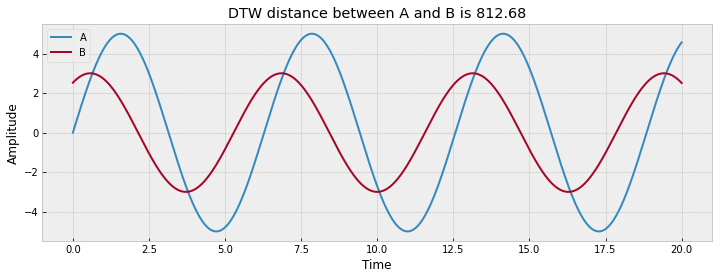

In [2]:
time = np.linspace(0,20,1000)
amplitude_a = 5*np.sin(time)
amplitude_b = 3*np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
_ = plt.plot(time, amplitude_a, label='A')
_ = plt.plot(time, amplitude_b, label='B')
_ = plt.title('DTW distance between A and B is %.2f' % distance)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Time')
_ = plt.legend()

In [3]:
m._dist_matrix(np.array([[1, 2], [4, 5]]), np.array([[4,5], [7,8]]))

array([[ 6., 12.],
       [ 0.,  6.]])

In [4]:
m = KnnDtw(fdist="euclid")
m._dist_matrix(np.array([[1, 2], [4, 5]]), np.array([[4,5], [7,8]]))

array([[4.24264069, 8.48528137],
       [0.        , 4.24264069]])

# Dataset

In [5]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1

In [6]:
!unzip UCI\ HAR\ Dataset.zip

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

https://github.com/pdelboca/human-activity-recognition-using-smartphones/tree/master/UCI%20HAR%20Dataset

In [7]:
# Import the HAR dataset
x_train_file = open('/content/UCI HAR Dataset/train/X_train.txt', 'r')
y_train_file = open('/content/UCI HAR Dataset/train/y_train.txt', 'r')

x_test_file = open('/content/UCI HAR Dataset/test/X_test.txt', 'r')
y_test_file = open('/content/UCI HAR Dataset/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

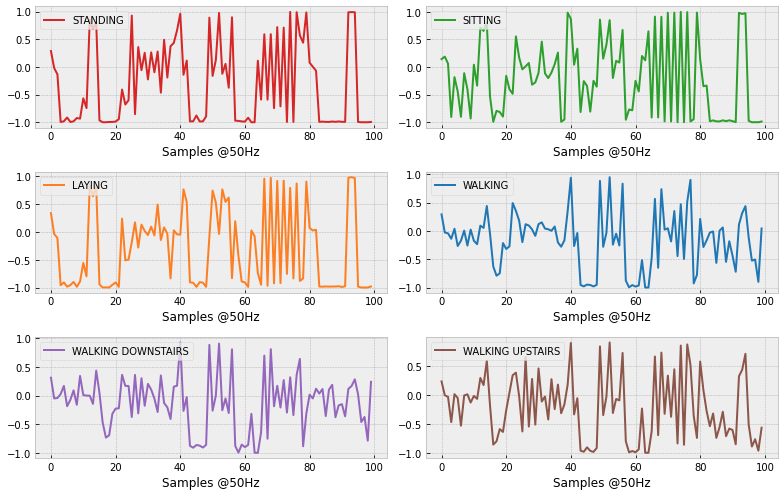

In [8]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:100], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [9]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [10]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [11]:
DATASET_PATH = "/content/UCI HAR Dataset/"

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [12]:
X_train.shape

(7352, 128, 9)

In [13]:
y_train.shape

(7352, 1)

In [14]:
X_train[r,:100,6].shape

(100,)

In [15]:
y_train[100][0]

0

In [16]:
X_train[r, :100, 6]

array([0.7770417, 0.7882454, 0.7383156, 0.7156667, 0.6929365, 0.6013269,
       0.6261297, 0.7299576, 0.7907816, 0.8479424, 0.8510189, 0.872542 ,
       0.9794216, 1.047836 , 1.066059 , 1.005309 , 0.9455078, 1.094791 ,
       1.305575 , 1.338434 , 1.173309 , 0.9679728, 0.913685 , 0.9422365,
       0.9809946, 1.064388 , 1.078707 , 0.9909071, 0.9146324, 0.8970635,
       0.9412579, 0.9953213, 1.008174 , 0.9987326, 0.9467438, 0.844576 ,
       0.7443873, 0.6878158, 0.6878276, 0.7011151, 0.706081 , 0.729417 ,
       0.7946022, 0.9076493, 0.999472 , 1.038279 , 1.082701 , 1.144041 ,
       1.186567 , 1.179226 , 1.167133 , 1.207791 , 1.250012 , 1.263301 ,
       1.240727 , 1.195023 , 1.177435 , 1.125293 , 1.049247 , 1.029921 ,
       1.002587 , 0.9611838, 0.9214769, 0.8923208, 0.9461646, 1.016134 ,
       1.030573 , 1.006865 , 0.9520242, 0.907048 , 0.8767445, 0.855666 ,
       0.8156656, 0.7393962, 0.7305757, 0.7640691, 0.7623775, 0.7820564,
       0.8075046, 0.8131099, 0.8161295, 0.8235833, 

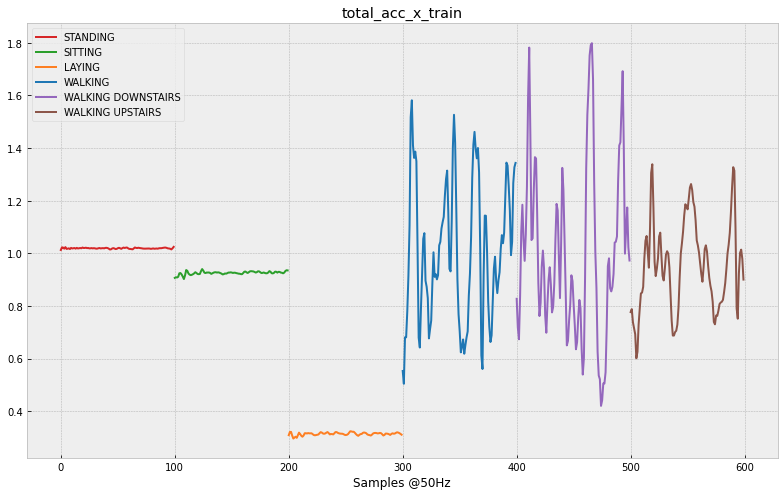

In [17]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']
plt.title('total_acc_x_train')
for i, r in enumerate([0,27,65,100,145,172]):
  plt.plot(np.arange(100*i, 100*(i+1)), X_train[r, :100, 6], label=labels[y_train[r][0] + 1], color=colors[i], linewidth=2)
plt.xlabel('Samples @50Hz')
plt.legend(loc='upper left')
plt.tight_layout()

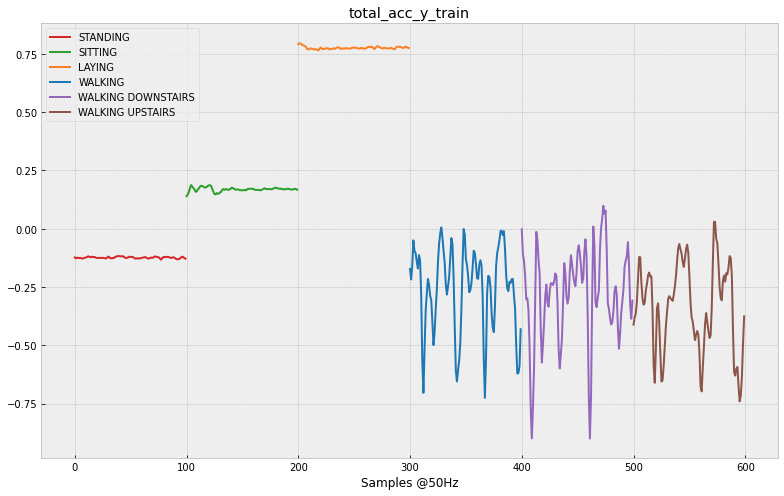

In [18]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']
plt.title('total_acc_y_train')
for i, r in enumerate([0,27,65,100,145,172]):
  plt.plot(np.arange(100*i, 100*(i+1)), X_train[r, :100, 7], label=labels[y_train[r][0] + 1], color=colors[i], linewidth=2)
plt.xlabel('Samples @50Hz')
plt.legend(loc='upper left')
plt.tight_layout()

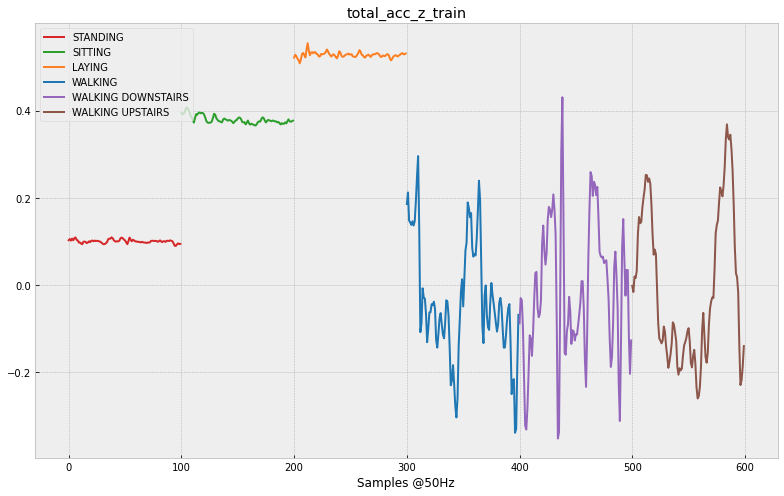

In [19]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']
plt.title('total_acc_z_train')
for i, r in enumerate([0,27,65,100,145,172]):
  plt.plot(np.arange(100*i, 100*(i+1)), X_train[r, :100, 8], label=labels[y_train[r][0] + 1], color=colors[i], linewidth=2)
plt.xlabel('Samples @50Hz')
plt.legend(loc='upper left')
plt.tight_layout()

# Evaluation

## KNN with Euclid distance

In [ ]:
m = KnnDtw(n_neighbors=1, max_warping_window=10, fdist="euclid")
m.fit(x_train[::10], y_train[::10])
label, proba = m.predict(x_test[::10])

In [ ]:
print(x_train.shape)

In [ ]:
print(x_train[::10].shape)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label, y_test[::10],
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

## KNN with DTW distance

In [ ]:
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_train[::10], y_train[::10])
label, proba = m.predict(x_test[::10])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label, y_test[::10],
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

## Change max_warping_window

In [ ]:
import time

time_taken = []
windows = [1,2,5,10,50,100,500,1000,5000]

for w in windows:
    begin = time.time()
    
    t = KnnDtw(n_neighbors=1, max_warping_window=w)
    t.fit(x_train[:20], y_train[:20])
    label, proba = t.predict(x_test[:20])
    
    end = time.time()
    time_taken.append(end - begin)

fig = plt.figure(figsize=(12,5))
_ = plt.plot(windows, [t/400. for t in time_taken], lw=4)
plt.title('DTW Execution Time with \nvarying Max Warping Window')
plt.ylabel('Execution Time (seconds)')
plt.xlabel('Max Warping Window')
plt.xscale('log')

# UCI HAR data

In [ ]:
import pandas as pd
train = pd.read_csv('train.csv')
print(train.shape)

In [ ]:
train.head(3)

# SVM

In [ ]:
from sklearn import svm
clf = svm.SVC(C=10, kernel='rbf')
clf.fit(x_train[::10], y_train[::10])
label = clf.predict(x_test[::10])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label, y_test[::10],
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])

# Neural Network

In [ ]:
# Importing libraries
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from tensorflow.keras import optimizers

# Initiliazing the sequential model
model = Sequential()
# Adding 3 dense hidden layers with sigmoid activation
model.add(Dense(256, input_dim=len(x_train[0]), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
# Adding a dense output layer with sigmoid activation
model.add(Dense(6, activation='softmax'))
model.summary()

In [ ]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

# Training the model
model.fit(x_train[::10], 
          y_train[::10],
          batch_size=128,
          epochs=100)
label = model.predict(x_test[::10])
loss, acc = model.evaluate(x_test[::10], y_test[::10])
loss, acc

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label.argmax(axis=1), y_test[::10],
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label.argmax(axis=1), y_test[::10])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])